#Table of Contents 
01. Abstract
02. Importing the Libaries
03. Exploring the data and data preprocessing
>03.1 Removing outliers <br />
>03.2 Checking Skewness <br />
>03.3 Correlation analysis <br />
>03.4 Feature Engineering and missing data processing<br/>
>03.5 Skewness<br/>
04. Modeling
>04.1 Cross Validation <br/>
>04.2 Models and Training <br/>
>04.3 Kagle Submission score<br/>
05. Neural Network Model 
>05.1 Mini-batches creation<br/>
>05.2 Dropout<br/>
>05.3 Regularization<br/>
>05.4 ANN model creation<br/>
>05.5 Training and validation<br/>
>05.6 Grid Search<br/>
>05.7 Ensembling<br/>
>05.8 Final output generation<br/>
>05.9 Kaggle Submission Score<br/>
06. Conclusion
07. References 


#01. Abstract

---
In this assignment an attempt was made to clean the data, analyze it and fit it to a model to predict the outcome. First the data was acquired and and environment was created for working on the data. On the next step the data was explored and featured engineered. Then we hot encoded the data and fitted a model to predict the houseprice.  

#02. Importing the Libaries 

First of all we are going to import libaries. Here Pandas is used for data manipulation, numpy is used for mathematical computation and matplotlib & seaborn is used for visualisation.

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import preprocessing
sns.set(style='white', context='notebook', palette='deep')
import tensorflow as tf
from scipy import stats
from scipy.stats import norm, skew
from scipy.special import boxcox1p
from scipy.stats.stats import pearsonr
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display

Now we will import algorithms that we will use for modeling. We will also import packages which we will use  preprocessing, optimising parameters, sampling and visualization. 

In [0]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor, ExtraTreesRegressor
import xgboost as xgb
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import mean_squared_error
from tensorflow.python.framework import ops
import sklearn
from sklearn.model_selection import ParameterGrid
import logging
import lightgbm as lgb
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import cross_val_score, train_test_split
mycols = ["#ffd966", "#dab3ff", "#ffb366", "#00cc99", "#66c2ff", "#c2c2d6", "#5cd6d6", "#85e085", "#ffb3b3"]
sns.set_palette(palette = mycols, n_colors = 4)

We are going to ignore any depreciation warning that we may get. 

In [0]:
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn 
warnings.filterwarnings("ignore", category=DeprecationWarning)

Now we will import the train and test dataset.

In [0]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

Here all the tools and libraries necessary were imported. Pandas is used to read a CSV file. "pd.read_csv" method is used to create a dataframe from a csv file.


Now to check the data we can write

In [0]:
print ("Train data shape:", train.shape)
print ("Test data shape:", test.shape)

Train data shape: (1460, 81)
Test data shape: (1459, 80)


We can see that train has 81 columns and test has 80 columns. Test data having only 80 columns is due to test data not including final sales price information. We can inspect a few rows using the train.head() meathod.



In [0]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


We will use Matplotlib to plot our data so that we can visualize the data to understand the distribution of data, checking outilers and percept other patterns. 

#03. Exploring the data and  data preprocessing

We are going to save the first column "ID" and then drop it as it doesn't serve our purpose. 

In [0]:
train_ID = train['Id']
test_ID = test['Id']

train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

Now we will check the data size of train and test set.

In [0]:
print ("Train data shape:", train.shape)
print ("Test data shape:", test.shape)

Train data shape: (1460, 80)
Test data shape: (1459, 79)


##03.1 Removing outliers

The data labeled GrLivArea as an outlier. We can plot first and then take measures against this. 

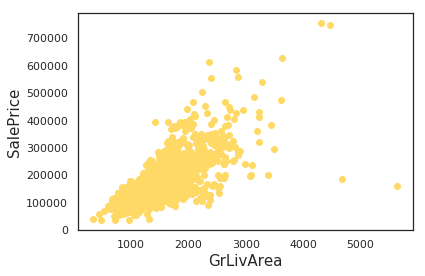

In [0]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('GrLivArea', fontsize=15)
plt.show()

We can see that there are some prices which are large and in small numbers so we can detect them as outliers and remove them for better prediction. 

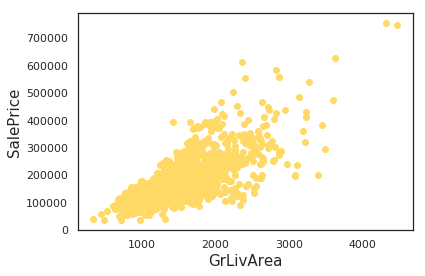

In [0]:
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('GrLivArea', fontsize=15)
plt.show()

In [0]:
trainNoOutlier = train.copy()
testNoOutlier = test.copy()

##03.2 Checking Skewness 

Skewness is a measure of the shape of the distributed values. We will check if our target variable is skewed or not. 

Skew is: 1.8812964895244009


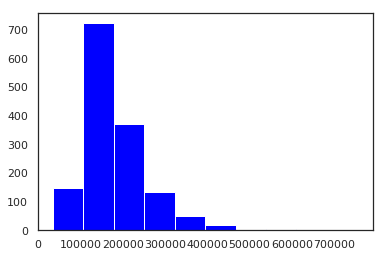

In [0]:
print ("Skew is:", train.SalePrice.skew())
plt.hist(train.SalePrice, color='blue')
plt.show()

We can see that the distribution is positively skewed as the tail is longer on the right. Now we will transform the data using np.log() , recalculate the skewness replot the data. If the value becomes closer to 0 that will mean the the data is resembling a normal distribution.  

Skew is: 0.12157976050304879


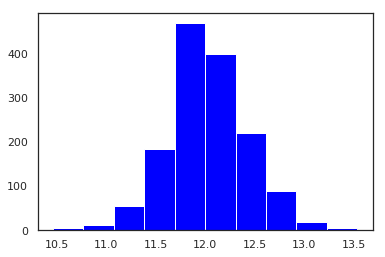

In [0]:
train["SalePrice"] = np.log1p(train["SalePrice"])
target=train["SalePrice"]
print ("Skew is:", target.skew())
plt.hist(target, color='blue')
plt.show()

The skew seems to have been corrected.

##03.3 Correlation analysis

Now we will see which factors are correlated to houseprice the most. 

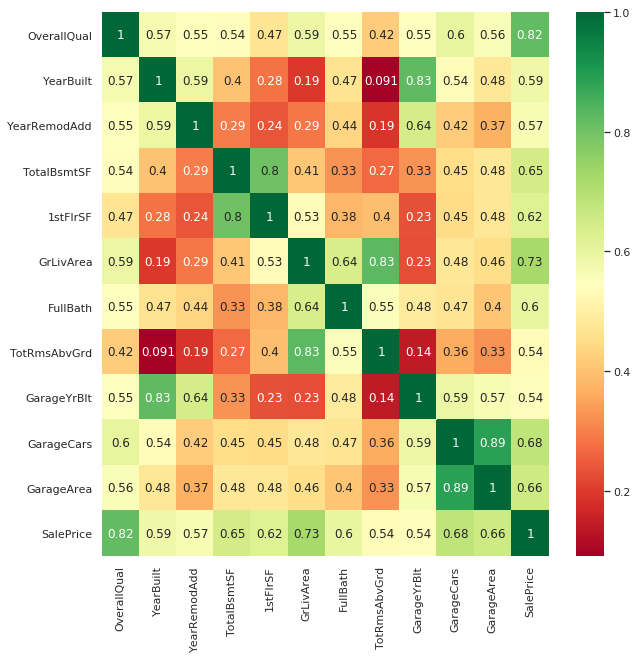

In [0]:
corrmat = train.corr()
top_corr_features = corrmat.index[abs(corrmat["SalePrice"])>0.5]
plt.figure(figsize=(10,10))
g = sns.heatmap(train[top_corr_features].corr(),annot=True,cmap="RdYlGn")

We can see that OverallQual, GrLivArea and TotalBsmtSF are most positively correlated to houseprice. 

##03.4 Feature Engineering and missing data processing

We will concatenate the datasets for preprocessing first and again split it when we want to implement model. 

In [0]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
trainRaw = train.copy()
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2917, 79)


First of all we will find the missing values and then we will go to each column and take necessary actions. 

In [0]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 1
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing data' :all_data_na})
missing_data.head(30)

,Missing data
PoolQC,0.996915
MiscFeature,0.964004
Alley,0.932122
Fence,0.804251
FireplaceQu,0.486802
LotFrontage,0.166610
GarageQual,0.054508
GarageCond,0.054508
GarageFinish,0.054508
GarageYrBlt,0.054508


Now we will sequentially deal with the columns which have missing values. 

We can see that majority of the values of the pool column is null meaning there is no pool so we can replace thos with null

In [0]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")

We are going to give the same treatment to other missing values which have been defined as NA which means there is nothing in data description.

In [0]:
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

For LotFrontage we are going to use the median value assuming that similarity to other houses. 

In [0]:
all_data["LotFrontage"] = all_data.groupby(
    "Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

For GarageType, GarageFinish, GarageQual and GarageCond we will fill the missing data with None. 

In [0]:
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    all_data[col] = all_data[col].fillna('None')

As no garage is the same as no car in garage we will fill GarageYrBlt, GarageArea and GarageCars with 0.

In [0]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

We will do the same for BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath for having no basement as there is missing value.  

In [0]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

We will think of NaN as having nothing and fill the values of such columns with 'None'.

In [0]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

For MasVnrType we will fill it with 'None'. 

In [0]:
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")

For MasVnrType we will fill it with 0.

In [0]:
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

In [0]:
all_data['MSZoning'].value_counts()

RL         2263
RM          460
FV          139
RH           26
C (all)      25
Name: MSZoning, dtype: int64

In MSZoning the most seen value is "RL" so we will fill the missing values with it. 

In [0]:
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

In [0]:
all_data['Utilities'].value_counts()

AllPub    2914
NoSeWa       1
Name: Utilities, dtype: int64

Here we see that most values are of the same category so we will drop it as it won't affect our model. 

In [0]:
all_data = all_data.drop(['Utilities'], axis=1)

In data description NA is described as typical so we will do this. 

In [0]:
all_data["Functional"] = all_data["Functional"].fillna("Typ")

For Electrical,KitchenQual, Exterior1st, Exterior2nd, SaleType we will replace the missing values with most used keyword. 

In [0]:
mode_col = ['Electrical','KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType']
for col in mode_col:
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

In MSSubClass NA means the is nothing so we will fill it with 'None'.

In [0]:
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

Now we will check if there are any missing values which we have left. 

In [0]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Value' :all_data_na})
missing_data.head()

,Missing Value


Seems like there is none. 

In [0]:
train_noMissing = all_data[:ntrain]
test_noMissing = all_data[ntrain:]

We will calculate the total are available as it plays an important factor in the model.

In [0]:
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

There are columns which have numerical values but is actually categorical. We have to convert them to or else they will be treated as numerical values. We will make them into strings. 

In [0]:
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
all_data['OverallCond'] = all_data['OverallCond'].astype(str)
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

We can't work with ann text data so for data which has categoricla text as values we will convert them into understandable numberical data and for that we will use label encoder. 

In [0]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 
        'KitchenQual', 'BsmtFinType1', 'BsmtFinType2', 'Functional', 'Fence', 
        'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 
        'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))        
print('Shape of all_data: {}'.format(all_data.shape))

Shape of all_data: (2917, 79)


Copy of this datasets will be used later so we will create it here.

In [0]:
trainFeatured = train.copy()
testFeatured = test.copy()

##03.5 Skewness

We will now check again which columns in our dataset is skewed and then take measures accordingly 

In [0]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nThe Skewed features are: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(20)


The Skewed features are: 



,Skew
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080
LandSlope,4.973254
KitchenAbvGr,4.300550
BsmtFinSF2,4.144503
EnclosedPorch,4.002344
ScreenPorch,3.945101


We can see that there are many features which are skewed. Previously we used log transform to fix the skewness of the Saleprice. This was done so that our data looks normally distributed. We will do the same thing here but now we will use box cox transformation which will reduce the skewness. 

In [0]:
skewness = skewness[abs(skewness) > 0.75]
print("We will transform {} skewed features".format(skewness.shape[0]))
from scipy.special import boxcox1p
skewed_features = skewness.index
lamda = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lamda)

We will transform 59 skewed features


Now that we are done with the skewed features we will work with the dummy categorical feastures. 

In [0]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2917, 220)


We are close to modeling after dealing with our data. So we will now create train and test datasets. 

In [0]:
train = all_data[:ntrain]
test = all_data[ntrain:]

In [0]:
trainFinal = train.copy()
testFinal = test.copy()

#04. Modeling

##04.1 Cross Validation

When we train our model we will have to calculate error to evaluate. We will use cross validation for it. 

In [0]:
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, 
                                   scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In this model we are going to apply different models to calculate our error and finally we will make mean of all the models to get the final score. 

##04.2 Models and Training

We are going to use LASSO as the first model. LASSO is Least Absolute Shrinkage Selector Operator and it uses L1 regularization technique. 

In [0]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=23))
score = rmsle_cv(lasso)
print("Lasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
LassoMd = lasso.fit(train.values,y_train)

Lasso score: 0.1115 (0.0074)



We will now use Ridge Regression and it uses L2 regularization technique. We can use it to prevent multicollinearity as it shrinks the parameter. It also reduces the coefficient which in result reduces model complexity. 

In [0]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
KRRMd = KRR.fit(train.values,y_train)

Kernel Ridge score: 0.1153 (0.0075)



By combining L1 and L2 regularization techique we get Elastic Net Regression and we will implement this now. 

In [0]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, 
                                                      random_state=23))
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
ENetMd = ENet.fit(train.values,y_train)

ElasticNet score: 0.1116 (0.0074)



Now we will use Gradient Boosing Algorithm. 

In [0]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =23)
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
GBoostMd = GBoost.fit(train.values,y_train)

Gradient Boosting score: 0.1177 (0.0067)



Now we will implement XGB model with the best parameters available.

In [0]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                            learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1, 
                             random_state =7, nthread = -1)
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.1168 (0.0058)



Now we will implement LGB model with the best parameters available.

In [0]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))


LGBM score: 0.1167 (0.0072)



We will average the models using Base Estimator, RegressorMixin and TransformerMixin now. We will use clone of the original model to fit in the data and then train the model. After we have trained the model we will predict the model and average them finally. 


In [0]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        for model in self.models_:
            model.fit(X, y)
        return self
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

In [0]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))
score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.1090 (0.0072)



BaseEstimator provides among other things a default implementation for the get_params and set_params methods. This is useful to make the model grid search-able with GridSearchCV for automated parameters tuning and behave well with others when combined in a Pipeline. 

We will first fit the data and we will fit it on the clones which were made from the original model. After that we will train the models based in clones and then create predictions which are out-of-fold. We will need this to train the cloned models. In the next step we will train the model using out of fold predictions as new feature. At last we will use the averaged prediction for the final prediction.  

In [0]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now training the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #The predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

We will now find out the rmsle score for the averaged model. 

In [0]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)
score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.1085 (0.0072)


In [0]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

Now we will find out the Rmsle score of stacked-averaged-models

In [0]:
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print('Rmsle of stacked-averaged-models: ',rmsle(y_train, stacked_train_pred))

Rmsle of stacked-averaged-models:  0.07882879244737684


Now we will find out the Rmsle score of XGBoost.

In [0]:
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print('Rmsle of XGboost: ',rmsle(y_train, xgb_train_pred))

Rmsle of XGboost:  0.07900074237023577


Now we will find out the Rmsle score of LightGBM.

In [0]:
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
print('Rmsle of LightGBM: ',rmsle(y_train, lgb_train_pred))

Rmsle of LightGBM:  0.07343743130986105


Now we will take the mean of all model's predictions. 

In [0]:
finalModel = (np.expm1(LassoMd.predict(test.values)) + 
           np.expm1(KRRMd.predict(test.values)) + 
           np.expm1(ENetMd.predict(test.values)) + np.expm1(GBoostMd.predict(test.values)) ) / 4
finalModel

array([120832.5717337 , 163046.1795949 , 185837.34579419, ...,
       171145.07330408, 113712.06161851, 222708.18509977])

Now we will make the submission file to submit it Kaggle. 

In [0]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = finalModel
sub.to_csv('submission.csv',index=False)

##04.3 Kagle Submission score
![alt text](https://puu.sh/DFyMF/c60b9a1984.png)

#05. Neural Network Model 

Here we will use Tensorflow's low level API to implement a neural network model. We will use grid search to find the best parameters so that our error is low. 

We are going to make necessary arrangements to get the data fisrt. 

In [0]:
zero= 0

## 05.1 Mini-batches creation

We are going to make mini-batches which will be used to calculate and update error in gradient descent. 

In [0]:
def mini_batches(train_set, train_labels, mini_batch_size):
    
    set_size = train_set.shape[zero]
    batches = []
    num_complete_minibatches = set_size // mini_batch_size

    for k in range(zero, num_complete_minibatches):
        mini_batch_x = train_set[k * mini_batch_size: (k + 1) * mini_batch_size]
        mini_batch_y = train_labels[k * mini_batch_size: (k + 1) * mini_batch_size]
        mini_batch = (mini_batch_x, mini_batch_y)
        batches.append(mini_batch)
    if set_size % mini_batch_size != zero:
        mini_batch_x = train_set[(set_size - (set_size % mini_batch_size)):]
        mini_batch_y = train_labels[(set_size - (set_size % mini_batch_size)):]
        mini_batch = (mini_batch_x, mini_batch_y)
        batches.append(mini_batch)

    return batches

As we need numerical values to fit the model and we may have categorical values in the dataset we will one hot encode the values so get numerical values. 

In [0]:
def pre_process_data(df):
    df = pd.get_dummies(df)
    return df

We will declare placeholders now as we will need it to feed data into it later. 

In [0]:
def create_placeholders(input_size, output_size):
  x = tf.placeholder(shape=(None, input_size), dtype=tf.float32, name="X")
  y = tf.placeholder(shape=(None, output_size), dtype=tf.float32, name="Y")
  return x, y

We will implement forward propagation and dropout in out model. 

## 05.2 Dropout

We will implement forward propagation and dropout in out model. Using dropout will improve our accuracy as we will be dropping the nodes which have less activation score. <br/>
Parameter explanation: <br/>
x: gives us information which the model uses to send to each layer and finally output is produced. It is an array. <br/>
parameters: This is the output. <br/>
keep_prob: This gives us the probability of whether a node will be dropped out or not. <br/>
hidden_activation: Here we declared which function we will use for the layers. Here, we will use "relu"



In [0]:
def forward_propagation(x, parameters, keep_prob=1, hidden_activation='relu'):
  a_dropout = x
  n_layers = len(parameters) // 2  
  for l in range(1, n_layers):
        a_prev = a_dropout
        a_dropout = linear_activation_forward(a_prev, parameters['w%s' % l], 
                                              parameters['b%s' % l], hidden_activation)
        if keep_prob < 1:
            a_dropout = tf.nn.dropout(a_dropout, keep_prob)
  al = tf.matmul(a_dropout, parameters['w%s' % n_layers]) + parameters['b%s' % n_layers]
  return al

Now we will implement linear activation function. It will return us an output of the activation function. 

Parameter explanation: <br/>
a_prev: This is the size of previous layer which is used as input. <br/>
w: This contains weight which has the current and previous layers size in an array. <br/>
b: This is the bias vector. This also is an array which contains current layer's size.<br/>
activation: This contains the activation function used in this layer. <br/>


In [0]:
def linear_activation_forward(a_prev, w, b, activation):
    a = None
    if activation == "sigmoid":
        z = tf.matmul(a_prev, w) + b
        a = tf.nn.sigmoid(z)
    elif activation == "relu":
        z = tf.matmul(a_prev, w) + b
        a = tf.nn.relu(z)
    elif activation == "leaky-relu":
        z = tf.matmul(a_prev, w) + b
        a = tf.nn.leaky_relu(z)
    return a

Now we build function to initialize parameters which will take dimension of each layer as an array and will return python dictionary containing parameters. 

Parameter explanation: <br/>
layer_dims: This contains the dimension of layers in our network in the shape of an array. <br/>
weight_initializer: We are initializing the weights here. <br/>

In [0]:
def initialize_parameters(layer_dims, weight_initializer):
    parameters = {}
    n_layers = len(layer_dims) 
    for l in range(1, n_layers):
        if(weight_initializer == 'random_normal'):
            parameters['w' + str(l)] = tf.get_variable('w' + str(l), [layer_dims[l - 1], layer_dims[l]],
                                                   initializer = tf.random_normal_initializer)
        else:
            parameters['w' + str(l)] = tf.get_variable('w' + str(l), [layer_dims[l - 1], layer_dims[l]],
                                                   initializer = tf.contrib.layers.xavier_initializer())
        parameters['b' + str(l)] = tf.get_variable('b' + str(l), [layer_dims[l]], initializer=tf.zeros_initializer())

    return parameters

Now we will make a predict function to return the prediction and also a cost function is necessary to compute cost.

Parameter explanation: <br/>
data: contains the dataset. <br/>
cost3: This contains the output of the forward propagation. <br/>
y: This is a placeholder. 


In [0]:
def predict(data, parameters):
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)
        dataset = tf.cast(tf.constant(data), tf.float32)
        fw_prop_result = forward_propagation(dataset, parameters)
        prediction = fw_prop_result.eval()
    return prediction
def compute_cost(cost3, y):
    cost = tf.sqrt(tf.reduce_mean(tf.square(y - cost3)))
    return cost  

Now we will calculate the error between real and predicted datasets. From here we will get what percentage of our prediction is correct. 

In [0]:
def rmse(predictions, labels):
    prediction_size = predictions.shape[zero]
    prediction_cost = np.sqrt(np.sum(np.square(labels - predictions)) / prediction_size)
    return prediction_cost
def rmsle(predictions, labels):
    prediction_size = predictions.shape[zero]
    prediction_cost = np.sqrt(np.sum(np.square(np.log(predictions + 1) - np.log(labels + 1))) / prediction_size)
    return prediction_cost

## 05.3 Regularization

We will use L2 regularization on the model to get the updated cost value of the network. 

Parameters explanation: <br/>
cost: This defines the cost of the model. <br/>
l2_beta: This the value which will be used to normalize. <br/>
parameters: This gives us the weights from the model. 
n_layers: This will give us the number of layers. 


In [0]:
def l2_regularizer(cost, l2_beta, parameters, n_layers):
  
  regularizer = zero
  for i in range(1, n_layers):
    regularizer += tf.nn.l2_loss(parameters['w%s' % i])
    cost = tf.reduce_mean(cost + l2_beta * regularizer)
    return cost

In [0]:
def build_submission_name(layers_dims, num_epochs, lr_decay,
                          learning_rate, l2_beta, keep_prob, minibatch_size, num_examples):
  submission_name = 'ly{}-epoch{}.csv' \
        .format(layers_dims, num_epochs)
  if lr_decay != zero:
        submission_name = 'lrdc{}-'.format(lr_decay) + submission_name
  else:
        submission_name = 'lr{}-'.format(learning_rate) + submission_name
  if l2_beta > zero:
        submission_name = 'l2{}-'.format(l2_beta) + submission_name
  if keep_prob < 1:
        submission_name = 'dk{}-'.format(keep_prob) + submission_name
  if minibatch_size != num_examples:
        submission_name = 'mb{}-'.format(minibatch_size) + submission_name
  return submission_name

We will now create train, test and validation sets. We will also do some other works for the model. We will seperate Saleprice form the datasets and one hot encode again incase there still exists any categorical value. Also if there still remains any missing value we will fill it with zero. The we will use standard scaler for creating the datasets. 

In [0]:
def keep_every_nth_info(n):
    i = -1
    def filter_record(record):
        nonlocal i
        i += 1
        return int( i % n == 15)
    return filter_record
logging.getLogger('tensorflow').addFilter(keep_every_nth_info(15))
train = trainFeatured
test = testFeatured
print("Training examples = " + str(train.shape[zero]))
print("Test examples = " + str(test.shape[zero]))
print("Train shape: " + str(train.shape))
print("Test shape: " + str(test.shape))

train_raw_labels = trainNoOutlier['SalePrice'].to_frame().as_matrix()

train_pre = pre_process_data(train)
test_pre = pre_process_data(test)

train_pre, test_pre = train_pre.align(test_pre, join='outer', axis=1)

train_pre.replace(to_replace=np.nan, value=zero, inplace=True)
test_pre.replace(to_replace=np.nan, value=zero, inplace=True)


train_pre = train_pre.as_matrix().astype(np.float)
test_pre = test_pre.as_matrix().astype(np.float)

standard_scaler = preprocessing.StandardScaler()
train_pre = standard_scaler.fit_transform(train_pre)
test_pre = standard_scaler.fit_transform(test_pre)


X_train, X_valid, Y_train, Y_valid = train_test_split(train_pre, train_raw_labels, test_size=0.30, random_state=1)

input_size = train_pre.shape[1]
output_size = 1

Training examples = 1458
Test examples = 1459
Train shape: (1458, 80)
Test shape: (1459, 79)


We will define a function to calculate the cost of the model. 

In [0]:
def plot_model_cost(train_costs, validation_costs, set_optimizer, weight_initializer, hidden_activation):
    plt.plot(np.squeeze(train_costs), label='Train cost')
    plt.plot(np.squeeze(validation_costs), label='Validation cost')
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title('Optimizer: '+set_optimizer+' |  Weight-initializer: '+ weight_initializer+' | Activation: '+hidden_activation)
    plt.legend()
    plt.show()

## 05.4 ANN model creation

We will now create the ANN model with hidden layers, neurons, learning rate, hidden layer activation function and optimizers. They will all be tweakable. This model will train batch by batch by using the minibatches we created before. We will have 2 hidden layers and we will start with 310 hidden neurons. In dropout neuron we will use score of .65 as probability of keeping the neuron. For activation function we will use 'leaky-relu' as it will perform better. For epoch number we will use 1200 epochs. Our learning rate will change from when we start the training and we will use lr_decay to change it. We will use "RMS-prop" as the optimizer here. 

In [0]:
def model(train_set=X_train, train_labels=X_valid, validation_set=Y_train, validation_labels=Y_valid, 
          input_size=input_size, 
          hidden_neurons=310, output_size = output_size, learning_rate=1e-2, 
          num_epochs=1100,print_cost=False, 
          plot_cost=True, l2_beta=10, keep_prob=0.65,hidden_activation='leaky-relu', 
          return_best=False, minibatch_size=zero, 
          set_optimizer = 'RMS-Prop',weight_initializer='random_normal',show_result=True,lr_decay=zero):
    ops.reset_default_graph()
    layers_dims = [input_size, hidden_neurons, hidden_neurons, output_size]
    input_size = layers_dims[zero]
    output_size = layers_dims[-1]
    num_examples = train_set.shape[zero]
    n_layers = len(layers_dims)
    train_costs = []
    validation_costs = []
    best_iteration = [float('inf'), zero]
    best_params = None

    if minibatch_size == zero or minibatch_size > num_examples:
        minibatch_size = num_examples

    num_minibatches = num_examples // minibatch_size

    if num_minibatches == zero:
        num_minibatches = 1

    submission_name = build_submission_name(layers_dims, num_epochs, lr_decay, learning_rate, l2_beta, keep_prob,
                                            minibatch_size, num_examples)

    x, y = create_placeholders(input_size, output_size)
    tf_valid_dataset = tf.cast(tf.constant(validation_set), tf.float32)
    parameters = initialize_parameters(layers_dims, weight_initializer)

    fw_output_train = forward_propagation(x, parameters, keep_prob, hidden_activation)
    train_cost = compute_cost(fw_output_train, y)

    fw_output_valid = forward_propagation(tf_valid_dataset, parameters, 1, hidden_activation)
    validation_cost = compute_cost(fw_output_valid, validation_labels)

    if l2_beta > zero:
        train_cost = l2_regularizer(train_cost, l2_beta, parameters, n_layers)
        validation_cost = l2_regularizer(validation_cost, l2_beta, parameters, n_layers)

    if lr_decay != zero:
        global_step = tf.Variable(zero, trainable=False)
        learning_rate = tf.train.inverse_time_decay(learning_rate, global_step=global_step, decay_rate=lr_decay,
                                                    decay_steps=1)
        if(set_optimizer == 'adam'):
            optimizer = tf.train.AdamOptimizer(learning_rate).minimize(train_cost, global_step=global_step)
        else:
            optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(train_cost, global_step=global_step)
          
    else:
        if(set_optimizer == 'adam'):
            optimizer = tf.train.AdamOptimizer(learning_rate).minimize(train_cost)
        else:
            optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(train_cost)

    
    init = tf.global_variables_initializer()

    with tf.Session() as sess:
        
        sess.run(init)

        for epoch in range(num_epochs):
            train_epoch_cost = zero
            validation_epoch_cost = zero

            minibatches = mini_batches(train_set, train_labels, minibatch_size)

            for minibatch in minibatches:
                
                (minibatch_X, minibatch_Y) = minibatch
                feed_dict = {x: minibatch_X, y: minibatch_Y}

                
                _, minibatch_train_cost, minibatch_validation_cost = sess.run(
                    [optimizer, train_cost, validation_cost], feed_dict=feed_dict)

                train_epoch_cost += minibatch_train_cost / num_minibatches
                validation_epoch_cost += minibatch_validation_cost / num_minibatches

            if print_cost is True and epoch % (2000) == zero:
                print("Train cost after epoch %i: %f" % (epoch, train_epoch_cost))
                print("Validation cost after epoch %i: %f" % (epoch, validation_epoch_cost))

            if plot_cost is True and epoch % 9 == zero:
                train_costs.append(train_epoch_cost)
                validation_costs.append(validation_epoch_cost)

            if return_best is True and validation_epoch_cost < best_iteration[zero]:
                best_iteration[zero] = validation_epoch_cost
                best_iteration[1] = epoch
                best_params = sess.run(parameters)

        if return_best is True:
            parameters = best_params
        else:
            parameters = sess.run(parameters)

        train_rmse = rmse(predict(train_set, parameters), train_labels)
        validation_rmse = rmse(predict(validation_set, parameters), validation_labels)
        train_rmsle = rmsle(predict(train_set, parameters), train_labels)
        validation_rmsle = rmsle(predict(validation_set, parameters), validation_labels)
        if show_result is True:
            print('Train rmsle: {:.4f}'.format(train_rmsle))
            print('Validation rmsle: {:.4f}'.format(validation_rmsle))

        submission_name = 'tr_cost-{:.2f}-vd_cost{:.2f}-'.format(train_rmse, validation_rmse) + submission_name

        if return_best is True:
            print('Lowest rmse: {:.2f} at epoch {}'.format(best_iteration[zero], best_iteration[1]))

        if plot_cost is True:
            plot_model_cost(train_costs, validation_costs, set_optimizer, weight_initializer, hidden_activation)

        return train_rmsle, validation_rmsle, parameters, submission_name

## 05.5 Training and validation

Now we will look at the train and validation rmsle. 

Train rmsle: 0.2774
Validation rmsle: 0.2896


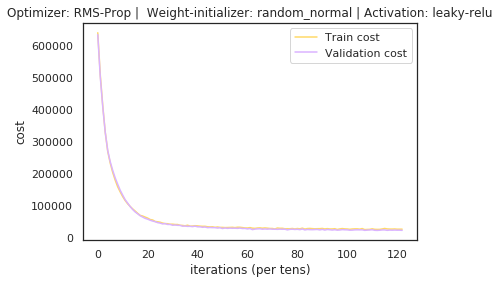

In [0]:
train_rmsle, validation_rmsle, parameters, submission_name = model(X_train, Y_train, X_valid, Y_valid)

Here we can see that the train and validation error is low. As the validation rmsle is high we will now try to minimize it. 

Now we will apply grid search to find out the best parameters for our model.

## 05.6 Grid Search

Grid search is basically giving some parameters to see which parameters are best suited for the best training result. In the result we will get the combination of the parameters and what their score is, from there we can choose the parameters which gives us the best result if implemented in training. 

For the optimizer we will use 'adam' and 'RMS-prop', for initializer we will use 'random-normal' and 'xavier' and for activation we will use 'relu', 'sigmoid' and 'leaky-relu'. Grid search will show us what all their train and validation error is by trying out all combinations possible from them.


In [0]:
param_grid = {'Optimizer':['adam','RMS-Prop'],
              'Initializer':['random-normal','xavier'],
              'Activation':['relu','sigmoid','leaky-relu']}
grid = ParameterGrid(param_grid)
all_combinations = []
all_train_error = []
all_validation_error = []
for params in grid:
    train_rmsle, validation_rmsle, parameters, submission_name = model(X_train, Y_train, X_valid, Y_valid,
                                                                       hidden_activation=params['Activation'],
                                                                       weight_initializer = params['Initializer'],
                                                                       show_result=False,
                                                                       set_optimizer = params['Optimizer'],
                                                                       plot_cost=False)
    all_combinations.append(str(list(params.values())))
    all_train_error.append(train_rmsle)
    all_validation_error.append(validation_rmsle)  
parameter_combinations = pd.DataFrame(
    {'Combination': all_combinations,
     'Train-error': all_train_error,
     'Validation-error': all_validation_error
    })
parameter_combinations = parameter_combinations.sort_values(by='Validation-error', ascending=True)
parameter_combinations[:10]

,Combination,Train-error,Validation-error
0,"['relu', 'random-normal', 'adam']",0.038947,0.059299
2,"['relu', 'xavier', 'adam']",0.038545,0.062381
8,"['leaky-relu', 'random-normal', 'adam']",0.073854,0.072850
10,"['leaky-relu', 'xavier', 'adam']",0.081612,0.077809
1,"['relu', 'random-normal', 'RMS-Prop']",0.079822,0.130236
3,"['relu', 'xavier', 'RMS-Prop']",0.076804,0.134654
11,"['leaky-relu', 'xavier', 'RMS-Prop']",0.291810,0.295041
9,"['leaky-relu', 'random-normal', 'RMS-Prop']",0.286313,0.311030
7,"['sigmoid', 'xavier', 'RMS-Prop']",1.085964,1.074364
5,"['sigmoid', 'random-normal', 'RMS-Prop']",1.131894,1.105374


Here we will decide which parameters to take depending on which validation error is the lowest. 

Here we can see that 'relu', 'xavier', 'adam' combination has the lowest validation error so we will choose these parameters and implement on our model. 

Train rmsle: 0.0404
Validation rmsle: 0.0557


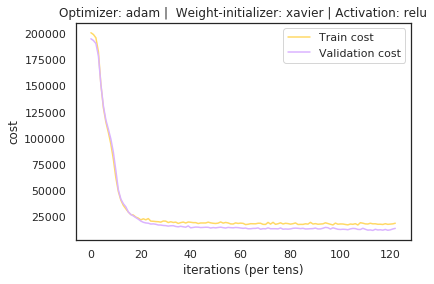

In [0]:
train_rmsle, validation_rmsle, parameters, submission_name = model(X_train, Y_train, X_valid, 
                                                                   Y_valid,set_optimizer = 'adam',
                                                                    weight_initializer='xavier',
                                                                   hidden_activation='relu' )

We can see the using the output of gridsearch we were able to minimize the validation loss. 

We will now apply gridsearch on hyperparameters to get further better result. 

In [0]:
param_grid = {'keep_prob':[0.5, 0.8, 1.0],
              'learn-rate':[0.01, 0.015,0.02,],
              'lr_decay':[0,0.001],
              'l2_beta':[5, 10]}
grid = ParameterGrid(param_grid)
all_combinations = []
all_train_error = []
all_validation_error = []
for params in grid:
    train_rmsle, validation_rmsle, parameters,submission_name = model(X_train, Y_train, X_valid, 
                                                                      Y_valid,hidden_activation='relu',
                                                        weight_initializer='xavier', set_optimizer = 'adam',
                                                        keep_prob=params['keep_prob'],
                                                        learning_rate=params['learn-rate'],
                                                        print_cost=False, plot_cost=False,show_result=False,
                                                        l2_beta=params['l2_beta'],return_best=False,
                                                        lr_decay=params['lr_decay'])
    all_combinations.append(str(params))
    all_train_error.append(train_rmsle)
    all_validation_error.append(validation_rmsle) 
pd.options.display.max_colwidth = 140 
parameter_combinations = pd.DataFrame(
    {'combination': all_combinations,
     'train-error': all_train_error,
     'validation-error': all_validation_error
    })
parameter_combinations = parameter_combinations.sort_values(by='validation-error', ascending=True)
parameter_combinations[:10]    

,combination,train-error,validation-error
23,"{'keep_prob': 0.8, 'l2_beta': 10, 'learn-rate': 0.02, 'lr_decay': 0.001}",0.033090,0.053476
7,"{'keep_prob': 0.5, 'l2_beta': 10, 'learn-rate': 0.01, 'lr_decay': 0.001}",0.035186,0.055065
18,"{'keep_prob': 0.8, 'l2_beta': 10, 'learn-rate': 0.01, 'lr_decay': 0}",0.034557,0.057397
9,"{'keep_prob': 0.5, 'l2_beta': 10, 'learn-rate': 0.015, 'lr_decay': 0.001}",0.043604,0.057822
17,"{'keep_prob': 0.8, 'l2_beta': 5, 'learn-rate': 0.02, 'lr_decay': 0.001}",0.035102,0.058295
11,"{'keep_prob': 0.5, 'l2_beta': 10, 'learn-rate': 0.02, 'lr_decay': 0.001}",0.047457,0.058308
21,"{'keep_prob': 0.8, 'l2_beta': 10, 'learn-rate': 0.015, 'lr_decay': 0.001}",0.029877,0.058309
22,"{'keep_prob': 0.8, 'l2_beta': 10, 'learn-rate': 0.02, 'lr_decay': 0}",0.037972,0.058714
14,"{'keep_prob': 0.8, 'l2_beta': 5, 'learn-rate': 0.015, 'lr_decay': 0}",0.034715,0.058716
5,"{'keep_prob': 0.5, 'l2_beta': 5, 'learn-rate': 0.02, 'lr_decay': 0.001}",0.047430,0.060349


We will again apply the best parameters in our model which is 'keep_prob': 1.0, 'l2_beta': 10, 'learn-rate': 0.02 and 'lr_decay': 0.

Train rmsle: 0.0158
Validation rmsle: 0.0746


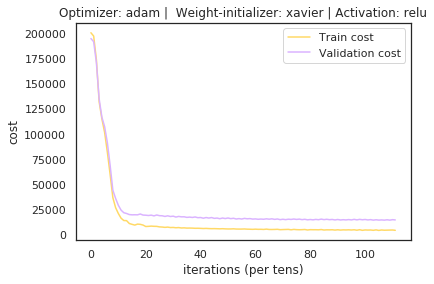

In [0]:
train_rmsle, validation_rmsle, parameters,submission_name = model(X_train, Y_train, X_valid, Y_valid,
                                                                  hidden_activation='relu',
                                                                  weight_initializer='xavier', 
                                                                  set_optimizer = 'adam',
                                                                  keep_prob=1,learning_rate=0.02, 
                                                                  num_epochs=1000,
                                                                  print_cost=False, 
                                                                  plot_cost=True,show_result=True,
                                                                  l2_beta=10,return_best=False,
                                                                  lr_decay=0.00,input_size=input_size)

We will see if we can include techniques like ensembling to better our results further. 

We will now train and test the data. 

Train rmsle: 0.0148
Validation rmsle: 0.0307


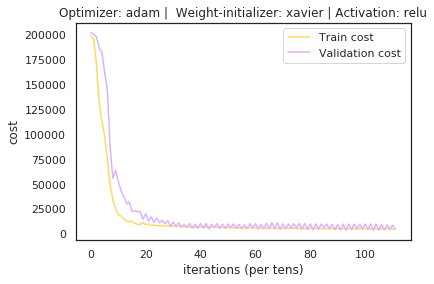

In [0]:
train = trainFeatured
test = testFeatured
train_raw_labels = trainNoOutlier['SalePrice'].to_frame().as_matrix()
train_pre = pre_process_data(train)
test_pre = pre_process_data(test)
train_pre, test_pre = train_pre.align(test_pre, join='outer', axis=1)
train_pre.replace(to_replace=np.nan, value=zero, inplace=True)
test_pre.replace(to_replace=np.nan, value=zero, inplace=True)
train_pre = train_pre.as_matrix().astype(np.float)
test_pre = test_pre.as_matrix().astype(np.float)
standard_scaler = preprocessing.StandardScaler()
train_pre = standard_scaler.fit_transform(train_pre)
test_pre = standard_scaler.fit_transform(test_pre)
input_size = train_pre.shape[1]
output_size = 1

X_train, X_valid, Y_train, Y_valid = train_test_split(train_pre, train_raw_labels, test_size=0.001, random_state=23)
train_rmsle, validation_rmsle, parameters,submission_name = model(X_train, Y_train, X_valid, Y_valid,
                                                                  hidden_activation='relu',
                                                                  weight_initializer='xavier', 
                                                                  set_optimizer = 'adam',
                                                                  keep_prob=1,learning_rate=0.02, 
                                                                  num_epochs=1000,
                                                                  print_cost=False, 
                                                                  plot_cost=True,show_result=True,
                                                                  l2_beta=10,return_best=False,
                                                                  lr_decay=0.00,input_size=input_size)
prediction = list(map(lambda val: float(val), predict(test_pre, parameters)))

We will now produce the output file to see what out kaggle score is by submitting it. 

In [0]:
sub = pd.DataFrame()

sub['Id'] = test_ID
sub['SalePrice'] = prediction

sub.to_csv('submission_DNN_NE.csv',index=False)

 Our submission scored 0.36900 which is not very good so we will try to improve it. 

## 05.7 Ensembling

To improve the score we will implement ensembling method and for that we need to train datasets again. First we will do it with the dataset which is without feature engineering. 

Train rmsle: 0.0177
Validation rmsle: 0.2540


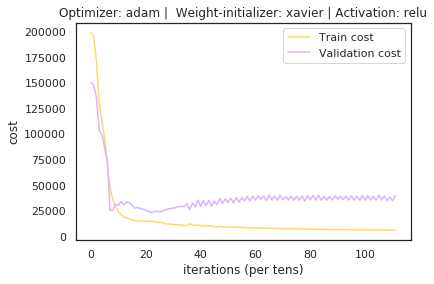

In [0]:
train = train_noMissing
test = test_noMissing
train_raw_labels = trainNoOutlier['SalePrice'].to_frame().as_matrix()
train_pre = pre_process_data(train)
test_pre = pre_process_data(test)
train_pre, test_pre = train_pre.align(test_pre, join='outer', axis=1)
train_pre.replace(to_replace=np.nan, value=zero, inplace=True)
test_pre.replace(to_replace=np.nan, value=zero, inplace=True)
train_pre = train_pre.as_matrix().astype(np.float)
test_pre = test_pre.as_matrix().astype(np.float)
standard_scaler = preprocessing.StandardScaler()
train_pre = standard_scaler.fit_transform(train_pre)
test_pre = standard_scaler.fit_transform(test_pre)
input_size = train_pre.shape[1]
output_size = 1

X_train, X_valid, Y_train, Y_valid = train_test_split(train_pre, train_raw_labels, test_size=0.001, random_state=1)
train_rmsle, validation_rmsle, parameters2,submission_name = model(X_train, Y_train, X_valid, Y_valid,
                                                                   hidden_activation='relu',
                                                                   weight_initializer='xavier', 
                                                                   set_optimizer = 'adam',
                                                                   keep_prob=1,learning_rate=0.02, 
                                                                   num_epochs=1000,
                                                                   print_cost=False, plot_cost=True,
                                                                   show_result=True,
                                                                   l2_beta=10,return_best=False,
                                                                   lr_decay=0.00,input_size=input_size)
prediction2 = list(map(lambda val: float(val), predict(test_pre, parameters2)))

Now we will train it on the dataset where feature engineering has been done and skew has been fixed. 

Train rmsle: 0.0191
Validation rmsle: 0.3274


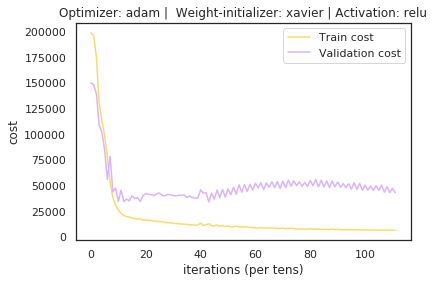

In [0]:
train = trainFinal
test = testFinal
train_raw_labels = trainNoOutlier['SalePrice'].to_frame().as_matrix()
train_pre = pre_process_data(train)
test_pre = pre_process_data(test)
train_pre, test_pre = train_pre.align(test_pre, join='outer', axis=1)
train_pre.replace(to_replace=np.nan, value=zero, inplace=True)
test_pre.replace(to_replace=np.nan, value=zero, inplace=True)
train_pre = train_pre.as_matrix().astype(np.float)
test_pre = test_pre.as_matrix().astype(np.float)
standard_scaler = preprocessing.StandardScaler()
train_pre = standard_scaler.fit_transform(train_pre)
test_pre = standard_scaler.fit_transform(test_pre)
input_size = train_pre.shape[1]
output_size = 1
X_train, X_valid, Y_train, Y_valid = train_test_split(train_pre, train_raw_labels, test_size=0.001, random_state=1)
train_rmsle, validation_rmsle, parameters3,submission_name = model(X_train, Y_train, X_valid, Y_valid,
                                                                  hidden_activation='relu',
                                                                  weight_initializer='xavier',
                                                                   set_optimizer = 'adam',
                                                                  keep_prob=1,learning_rate=0.02, 
                                                                   num_epochs=1000,
                                                                  print_cost=False, plot_cost=True,
                                                                   show_result=True,
                                                                  l2_beta=10,return_best=False,
                                                                  lr_decay=0.00,input_size=input_size)
prediction3 = list(map(lambda val: float(val), predict(test_pre, parameters3)))

We will now use ensemble to get our final score. 

In [0]:
ensemble =  np.multiply(prediction,  (0.35))+ np.multiply(prediction2, (0.35))+ np.multiply(prediction3, (0.30))

We will implement ensemble method again.

In [0]:
ensemble2 =  np.multiply(stacked_pred,(0.60))+ np.multiply(xgb_pred,(0.10))+ np.multiply(lgb_pred,(0.10))+ np.multiply(ensemble,(0.20))

## 05.8 Final output generation

Now we will generate our csv file to submit in kaggle. 

In [0]:
sub = pd.DataFrame()

sub['Id'] = test_ID
sub['SalePrice'] = ensemble2

sub.to_csv('submission_DNN_WD.csv',index=False)

##05.9 Kaggle Submission Score
![alt text](https://puu.sh/EuHCa/e86a289664.png)


# 06. Conclusion

We can see that a lot of technique was used to improve our score and emsembling certainly played a huge part in that. Valiadtion score let us know when to improve and mode and grid search helped use hugely to choose the best suited parameters throughout the model. Feature Engineering is the key thing in this model as we have to spend the most amount of time preproscessing any data. The further we can clean the data the further we can improve our model's score. 

#07. References 
1. https://www.kaggle.com/dimitreoliveira/house-prices-deep-learning-aproach-tensorflow <br />
2. https://www.kaggle.com/karthikramesh55/iowa-housing-price-prediction-regression-models/notebook?fbclid=IwAR0QixSNKX7WaVGc0yMYOL0S7RO7Lh3Z92BOiVArOIvr6Ik1w4COWxNnCFM <br />
3. https://www.dataquest.io/blog/kaggle-getting-started/ <br />
4. https://towardsdatascience.com/simple-house-price-predictor-using-ml-through-tensorflow-in-python-cbd2b637904b <br />
5. https://medium.com/@saxenarohan97/intro-to-tensorflow-solving-a-simple-regression-problem-e87b42fd4845?fbclid=IwAR15Tjc8pnQxLfVst3q2UcF5-DU9mfqrvDgnvD_SgWJp8hk1HGgIV9-4a1w <br />
6. https://www.tensorflow.org/guide/low_level_intro <br />
7. https://github.com/ageron/handson-ml/blob/master/09_up_and_running_with_tensorflow.ipynb?fbclid=IwAR3ONq_3VzaJ6bw_tdnu2Z-YNRe6cY7lmuZpyQxjbwW-CkAuc6LKDl0V36w <br />
8. https://github.com/IshrakHasin/House-price/tree/master <br />
9. https://medium.com/@_NicT_/my-first-kaggle-791e57cd5737 <br />
10. https://medium.com/@shantanusingh_71633/regression-in-neural-networks-using-tensorflow-low-level-apis-818b8bb7b433 <br />
11. https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/ <br />
12. https://nycdatascience.com/blog/student-works/predictive-modeling-on-house-prices-ames-iowa/ <br />
13. https://github.com/AdalbertoCq/Deep-Learning-Specialization-Coursera/blob/master/Neural%20Networks%20and%20Deep%20Learning/week4/deep_neural_network.py <br />